# Group 3 - In-class Presentation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
import requests
import io

In [2]:
# Download data file
url = 'https://raw.githubusercontent.com/OlekRomanko/teaching/master/datasets/customer_dbase_sel.csv'
r = requests.get(url, allow_redirects=True)
open('customer_dbase_sel.csv', 'wb').write(r.content)

df = pd.read_csv("customer_dbase_sel.csv")

## Dataset

We are going to use the dataset provided in-class on Week 3: `customer_dbase_sel.csv`.

It is an extract from IBM SPSS sample dataset with customer data which contains customer-specific data such as age, income, credit card spendings, commute type and time, etc. [Dataset source](http://www-01.ibm.com/support/knowledgecenter/SSLVMB_20.0.0/com.ibm.spss.statistics.help/data_files.htm)

- **custid** e.g. 0648-AIPJSP-UVM (customer id)
- **gender** e.g. Female or Male
- **age** e.g. 26
- **debtinc** e.g. 11.1 (debt to income ratio in %)
- **card** e.g. Visa, Mastercard (type of primary credit card)
- **carditems** e.g. 1, 2, 3 ... (# of primary credit card purchases in the last month)
- **cardspent** e.g 228.27 (amount in \$ spent on the primary credit card last month)
- **commute** e.g. Walk, Car, Bus (commute type)
- **commutetime** e.g. 22 (time in minutes to commute to work)
- **income** e.g. 16.00 (income in thousands \$ per year)
- **edcat** e.g. College degree, Post-undergraduate degree (education level)

In [3]:
df.head(2)

custid  gender  age age_cat  debtinc        card  carditems  \
0  3964-QJWTRG-NPN  Female   20   18-24     11.1  Mastercard          5   
1  0648-AIPJSP-UVM    Male   22   18-24     18.6        Visa          5   

   cardspent cardtype  creddebt  ... carown  region          ed_cat  ed_years  \
0      81.66     None      1.20  ...    Own  Zone 1    Some college        15   
1      42.60    Other      1.22  ...    Own  Zone 5  College degree        17   

                       job_cat employ_years      emp_cat retire annual_income  \
0  Managerial and Professional            0  Less than 2     No       31000.0   
1             Sales and Office            0  Less than 2     No       15000.0   

     inc_cat  
0  $25 - $49  
1  Under $25  

[2 rows x 30 columns]

## Question 1 - Bootstrapping

*In the context of testing hypothesis about comparing means of two groups (females and
males), bootstrap your data for comparing mean “amount spent on the primary credit card
last month” and “debt to income ratio” for the two groups. For each of these two cases, plot
two bootstrapped distributions (for males and females) and the distribution of the difference
in means (plot the original distribution of differences and a normalized one, if necessary).
Explain how you performed the bootstrapping and how many datapoints you average for
computing your means.*

In [4]:
print("Mean Values of Cardspent and Debtinc Grouped by Gender:")
table=df.groupby("gender")[['cardspent',"debtinc"]].mean()
display(table)

Mean Values of Cardspent and Debtinc Grouped by Gender:


cardspent   debtinc
gender                      
Female  323.343489  9.985221
Male    356.606840  9.929236

**--> Can we conclude that men spend more than women on average? Or that women have a higher debt-to-income ratio?**

This is only a sample of the population, therefore, to answer this question, we need to test if the difference is **statistically significant**. To do so, we are going to use the bootstrapping method.

**Bootstrapping Framework**

- Formulate the Hypotheses:
    - Null Hypothesis (H0): The means of the two groups are equal.
    - Alternative Hypothesis (Ha): The means of the two groups are not equal.

- Shift Both Groups to Have the Same Mean:

Calculate the overall mean of the combined dataset (both groups).
Shift both groups by subtracting their respective means from each data point. This step centers both groups around a common mean, which is the pooled mean.

- Bootstrap Sampling:

Randomly draw bootstrap samples with replacement from the shifted datasets. These samples should have the same size as the original datasets (here 5000).
For each bootstrap sample, calculate the difference in means between the two shifted groups.

- Calculate Bootstrap Replicates:

Repeat the previous step (bootstrap sampling and mean difference calculation) many times (here 20 000 times), generating a distribution of differences in means. Each value in this distribution is a bootstrap replicate.

- Calculate the Observed Difference:

Calculate the observed difference in means between the original, unshifted groups.

- Calculate the p-value:

Determine the fraction of bootstrap replicates that have a difference in means greater than or equal to the observed difference in means. This fraction is the p-value.

- Hypothesis Testing:

Compare the calculated p-value to a chosen significance level (alpha, typically set at 0.05).
If p-value ≤ alpha, reject the null hypothesis (H0). This suggests that there is a statistically significant difference between the means of the two groups.
If p-value > alpha, fail to reject the null hypothesis. This suggests that there is no statistically significant difference between the means of the two groups.

**Comment on the Choice of Bootstrapping Framework**

There are several variations of the bootstrapping framework. Some shift the mean before sampling, while others do not but instead normalize the difference distribution. In the end, the computed p-value is the same. The framework presented here has the main advantage of being very intuitive to understand. It was taken from one of the DataCamp courses.

Reference: [DataCamp Statistical Thinking in Python Part 2 - Introduction to Hypothesis Testing](https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2/introduction-to-hypothesis-testing?ex=12)

In [5]:
# Define a function for bootstrapping
def bootstrap(data, num_samples= 20000):
    means = []
    for _ in range(num_samples):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    return means

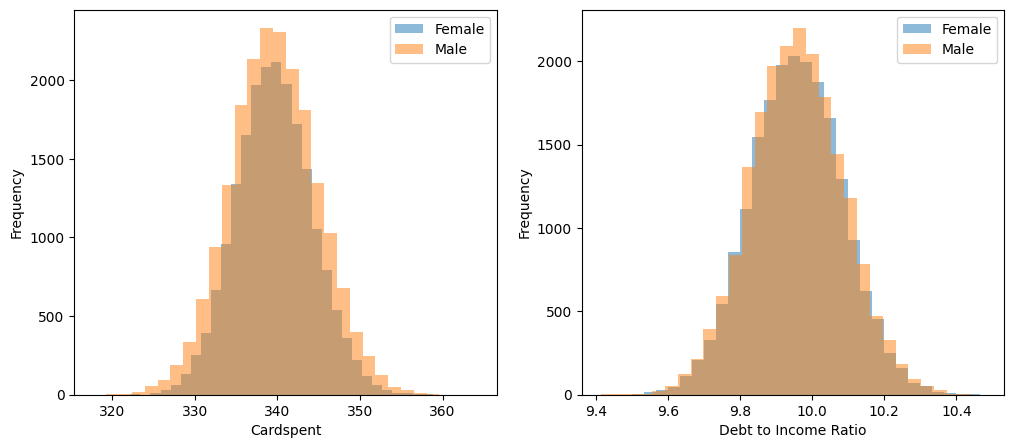

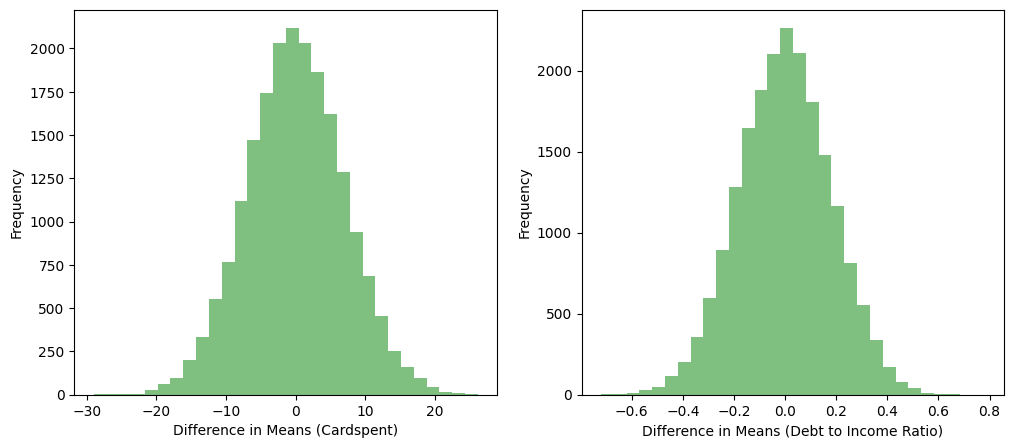

In [6]:
# Extract data for females and males

female_cardspent = df[df['gender'] == 'Female']['cardspent']
male_cardspent = df[df['gender'] == 'Male']['cardspent']
female_debtinc = df[df['gender'] == 'Female']['debtinc']
male_debtinc = df[df['gender'] == 'Male']['debtinc']

# Computed observed mean difference
observed_diff_cardspent = abs(female_cardspent.mean() - male_cardspent.mean())
observed_diff_debtinc = abs(female_debtinc.mean() - male_debtinc.mean())

# Shift Both Groups to Have the Same Mean
pooled_mean_cardpsent = df.cardspent.mean()
pooled_mean_debtinc = df.debtinc.mean()

female_cardspent = female_cardspent - female_cardspent.mean() + pooled_mean_cardpsent
male_cardspent = male_cardspent - male_cardspent.mean() + pooled_mean_cardpsent

female_debtinc = female_debtinc - female_debtinc.mean() + pooled_mean_debtinc
male_debtinc = male_debtinc - male_debtinc.mean() + pooled_mean_debtinc

# Bootstrap for cardspent
female_cardspent_bootstrap = bootstrap(female_cardspent)
male_cardspent_bootstrap = bootstrap(male_cardspent)

# Bootstrap for debtinc
female_debtinc_bootstrap = bootstrap(female_debtinc)
male_debtinc_bootstrap = bootstrap(male_debtinc)

# Plot bootstrapped distributions for cardspent
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(female_cardspent_bootstrap, bins=30, alpha=0.5, label='Female')
plt.hist(male_cardspent_bootstrap, bins=30, alpha=0.5, label='Male')
plt.xlabel('Cardspent')
plt.ylabel('Frequency')
plt.legend()

# Plot bootstrapped distributions for debtinc
plt.subplot(1, 2, 2)
plt.hist(female_debtinc_bootstrap, bins=30, alpha=0.5, label='Female')
plt.hist(male_debtinc_bootstrap, bins=30, alpha=0.5, label='Male')
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Frequency')
plt.legend()

plt.show()

# Calculate the distribution of differences in means
diff_means_cardspent = np.array(female_cardspent_bootstrap) - np.array(male_cardspent_bootstrap)
diff_means_debtinc = np.array(female_debtinc_bootstrap) - np.array(male_debtinc_bootstrap)

# Plot the distribution of differences in means
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(diff_means_cardspent, bins=30, alpha=0.5, color='g')
plt.xlabel('Difference in Means (Cardspent)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(diff_means_debtinc, bins=30, alpha=0.5, color='g')
plt.xlabel('Difference in Means (Debt to Income Ratio)')
plt.ylabel('Frequency')

plt.show()


The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

In [7]:
# Calculate the p-value using bootstrap
p_value_cardspent = (np.abs(diff_means_cardspent) >= np.abs(observed_diff_cardspent)).mean()
p_value_debtinc = (np.abs(diff_means_debtinc) >= np.abs(observed_diff_debtinc)).mean()

print("p-value cardspent = ", p_value_cardspent)
print("p-value debtinc = ", p_value_debtinc)


p-value cardspent =  0.0
p-value debtinc =  0.7556


In the case of amount spent on primary credit card, we conclude that men tend to charge more on their primary card (`p-value = 0 < 0.05`, statistically significant).

In the case of debt-to-income ratio, we conclude that there is no significant difference between men and women (`p-value = 0.759 > 0.05`, not statistically significant).

Comment: The p-values we obtained are almost identical to the ones computed using t-test in class and summarized below. The differences in p-values are proportional to the number of samples used for bootstrapping. The more samples we used, the better the approximation of the p-value.

In [8]:
female_cardspent = df[df['gender'] == 'Female']['cardspent']
male_cardspent = df[df['gender'] == 'Male']['cardspent']
female_debtinc = df[df['gender'] == 'Female']['debtinc']
male_debtinc = df[df['gender'] == 'Male']['debtinc']

print("T-test results for Cardspent comparison:")
tc, pc = stats.ttest_ind(female_cardspent, male_cardspent)
print ("t = %g  p = %g" % (tc, pc))

print("\nT-test results for Debtinc comparison:")
td, p = stats.ttest_ind(female_debtinc, male_debtinc)
print ("t-test: t = %g  p = %g" % (td, p))

T-test results for Cardspent comparison:
t = -4.74396  p = 2.15418e-06

T-test results for Debtinc comparison:
t-test: t = 0.308069  p = 0.758043


## Question 2 - ANOVA test

*Explain how you can do hypothesis testing for comparing more than two groups. Select three groups from the dataset and explain how you use analysis of variance (ANOVA) for hypothesis testing comparing means of three groups, provide your IPython notebook code and necessary plots to illustrate.*

We are going to perform an analysis of variance (ANOVA) to `compare the means of annual income` among `three` different `education groups`: `High school degree`, `College degree`, and `Post-undergraduate degree`.

**Rationale for the Chosen Categories:**

- `High School Degree`: This category represents individuals with the minimum level of formal education. We include this group to compare individuals with a basic education to those with higher levels of education. This serves as a baseline group.

- `College Degree`: This category represents individuals who have completed a college degree. It's a common educational milestone, and we want to see how income differs between those with a college education and those without.

- `Post-Undergraduate Degree`: This category includes individuals who have pursued education beyond college, such as graduate or professional degrees. These individuals often have specialized skills or qualifications, and we want to see if their higher level of education corresponds to higher incomes.

By selecting these three categories, we are examining the impact of education across a spectrum, from basic education to advanced degrees.
This choice allows us to answer the question regarding how education level influences annual income while considering both lower and higher levels of education.

In [9]:
# Group by education category and calculate the mean annual income
education_groups = df.groupby('ed_cat')['annual_income'].mean()

# Sort the groups by mean annual income in ascending order
education_groups_sorted = education_groups.sort_values()

# Print the sorted means
print(education_groups_sorted)

ed_cat
Did not complete high school    45248.688353
High school degree              47882.877148
Some college                    55079.840319
College degree                  65391.734052
Post-undergraduate degree       80016.620499
Name: annual_income, dtype: float64


`Step 1`: We extract the data for the `three education groups` by filtering the dataset based on education categories.

In [10]:
# Extract data for individuals with a "High school degree"
high_school_degree = df[df['ed_cat'] == 'High school degree']['annual_income']

# Extract data for individuals with a "College degree"
college_degree = df[df['ed_cat'] == 'College degree']['annual_income']

# Extract data for individuals with a "Post-undergraduate degree"
post_undergraduate_degree = df[df['ed_cat'] == 'Post-undergraduate degree']['annual_income']



---


**N.B:** It's vital to visualize the data to verify our argument so, we create box plots to visualize the distribution of annual income among the education groups.

In [11]:
# Reference for the 3 classes' statistics

import statistics

# Calculate distribution statistics for each education group
high_school_stats = {
    "Mean": statistics.mean(high_school_degree),
    "Median": statistics.median(high_school_degree),
    "Q1 (25th Percentile)": statistics.quantiles(high_school_degree, n=4)[0],
    "Q3 (75th Percentile)": statistics.quantiles(high_school_degree, n=4)[2],
    "Minimum": min(high_school_degree),
    "Maximum": max(high_school_degree),
    "Standard Deviation": statistics.stdev(high_school_degree),
}

college_stats = {
    "Mean": statistics.mean(college_degree),
    "Median": statistics.median(college_degree),
    "Q1 (25th Percentile)": statistics.quantiles(college_degree, n=4)[0],
    "Q3 (75th Percentile)": statistics.quantiles(college_degree, n=4)[2],
    "Minimum": min(college_degree),
    "Maximum": max(college_degree),
    "Standard Deviation": statistics.stdev(college_degree),
}

post_undergraduate_stats = {
    "Mean": statistics.mean(post_undergraduate_degree),
    "Median": statistics.median(post_undergraduate_degree),
    "Q1 (25th Percentile)": statistics.quantiles(post_undergraduate_degree, n=4)[0],
    "Q3 (75th Percentile)": statistics.quantiles(post_undergraduate_degree, n=4)[2],
    "Minimum": min(post_undergraduate_degree),
    "Maximum": max(post_undergraduate_degree),
    "Standard Deviation": statistics.stdev(post_undergraduate_degree),
}

# Print the statistics in a readable format
print("Statistics for High School Education Group:")
for key, value in high_school_stats.items():
    print(f"{key}: {value}")

print("\nStatistics for College Education Group:")
for key, value in college_stats.items():
    print(f"{key}: {value}")

print("\nStatistics for Post-Undergraduate Education Group:")
for key, value in post_undergraduate_stats.items():
    print(f"{key}: {value}")

Statistics for High School Education Group:
Mean: 47882.87714831318
Median: 34000.0
Q1 (25th Percentile): 21000.0
Q3 (75th Percentile): 59000.0
Minimum: 9000.0
Maximum: 424000.0
Standard Deviation: 43734.5383007431

Statistics for College Education Group:
Mean: 65391.73405211141
Median: 47000.0
Q1 (25th Percentile): 28500.0
Q3 (75th Percentile): 81500.0
Minimum: 9000.0
Maximum: 1073000.0
Standard Deviation: 70108.23597664219

Statistics for Post-Undergraduate Education Group:
Mean: 80016.62049861495
Median: 58000.0
Q1 (25th Percentile): 35000.0
Q3 (75th Percentile): 94000.0
Minimum: 9000.0
Maximum: 780000.0
Standard Deviation: 78895.88604041912


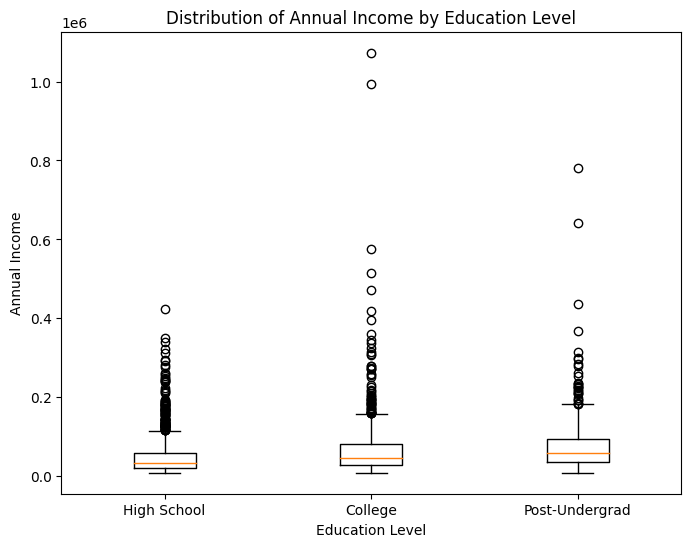

In [12]:
# Create box plots
plt.figure(figsize=(8, 6))
plt.boxplot([high_school_degree, college_degree, post_undergraduate_degree], labels=['High School', 'College', 'Post-Undergrad'])
plt.xlabel('Education Level')
plt.ylabel('Annual Income')
plt.title('Distribution of Annual Income by Education Level')
plt.show()

We can observe the central tendency, spread, and potential outliers in income within each education group.

`Post-Undergraduate` individuals tend to *have the highest median income*, followed by `College` then `High School` groups.


---



`Step 2`: Performing Analysis of Variance Test (ANOVA). We use the f_oneway function to perform ANOVA and compare the means of annual income among the three groups.

In [13]:
# Perform ANOVA
f_statistic, p_value = stats.f_oneway(high_school_degree, college_degree, post_undergraduate_degree)

But **why** One-Way ANOVA test and not the Two-way ANOVA?

In a one-way ANOVA, we are comparing the means of a *single dependent variable* (`annual income`) across *three independent* groups (`the education categories`: High school degree, College degree, and Post-undergraduate degree). This is evident from the use of the f_oneway function and the fact that we are comparing means across multiple groups with one independent variable.

`Step 3`: We interpret the ANOVA results by examining the p-value.

In [14]:
# Print the ANOVA results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpret the ANOVA results
if p_value < 0.05:
    print("Reject the null hypothesis. There are significant differences in annual income among the three education groups.")
else:
    print("Fail to reject the null hypothesis. There are no significant differences in annual income among the three education groups.")

F-statistic: 56.32323044054423
P-value: 9.575259603534483e-25
Reject the null hypothesis. There are significant differences in annual income among the three education groups.


- **F-statistic**: `56.32`
  - The F-statistic measures the significance of differences in means among education groups.

- **P-value**: `9.57 x 10^-25`
  - The p-value represents the probability that these differences occurred by chance.
  - The extremely small p-value indicates that the differences are highly unlikely to be random.

**Conclusion:**
  - **We reject the null hypothesis.**
  - **There are significant income differences** among "High school degree," "College degree," and "Post-undergraduate degree" groups.
  

The *analysis indicates that* ***education level significantly impacts income***, with meaningful differences observed between the education groups.

## **Question 3**

*In most cases we compare means in the hypothesis testing, either means of groups or sample
mean vs. population mean. Can we compare some other statistical properties in our hypothesis
testing like population proportion or population variance? Provide an IPython example
for hypothesis testing comparing something else than means*

While comparing means is a common application, we can also perform hypothesis tests for population proportions and variances, among other statistical properties.

To compare population proportions, we can use a hypothesis test called the Chi-squared test for independence. This test is used to determine if there is a significant association between two categorical variables.

Here's an example comparing population proportions using a Chi-squared test:

**1.** We start by importing the required libraries. In this case, we're using `chi2_contingency` from `scipy.stats` for the Chi-Square Test.

In [15]:
from scipy.stats import chi2_contingency

**2.** A `contingency table` is a cross-tabulation of the two categorical variables we want to analyze, in this case, 'Income Category' `(inc_cat)` and 'Car Ownership' `(carown)`. It shows the frequency distribution of each combination of categories.

In [16]:
order = ['Under $25', '$25 - $49', '$50 - $74', '$75 - $124', '$125+']
inc_cat = pd.Categorical(df.inc_cat, categories=order, ordered=True)

contingency_table = pd.crosstab(inc_cat, df['carown'])
contingency_table.index.name = "Inc_cat"
print(contingency_table)

carown      Lease   Own
Inc_cat                
Under $25     445   754
$25 - $49     248  1359
$50 - $74      56   679
$75 - $124     24   587
$125+           4   352


In the context of a Chi-Square test for independence, which is commonly used with contingency tables:

- The `rows` of the table represent categories from one categorical variable (e.g., 'Income Category' or 'inc_cat').
- The `columns` of the table represent categories from the other categorical variable (e.g., 'Car Ownership' or 'carown').
- Each `cell` within the table represents the count or frequency of observations that fall into a specific combination of categories.

We use `chi2_contingency` to perform the **Chi-Square Test** on the `contingency table`. This *function returns* the *Chi-Square statistic, p-value, degrees of freedom, and the expected frequencies.*

The Chi-Square Test for Independence helps us see if two categorical variables are related. We start by creating a table that counts how many times each combination of categories occurs. Then, we compare this to what we'd expect if there was no relationship. The Chi-Square statistic tells us how different these counts are. A small p-value suggests that the variables are related, while a large one suggests they're independent. With 95% confidence level, if p < 0.05 (significance level of 5%), it means car ownership and income categories are likely related/dependent on each other.

In [17]:
chi2, p, _, _ = chi2_contingency(contingency_table)

**3.** Finally, we interpret the results based on the calculated p-value. In hypothesis testing, we compare the p-value to a significance level (often denoted as alpha) to determine whether to reject or fail to reject the null hypothesis.

In [18]:
# Print the Chi-Square statistic and p-value
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("Reject the null hypothesis. There is a significant difference in car ownership across income categories.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in car ownership across income categories.")

Chi-Square Statistic: 524.0819336260239
P-value: 4.1407353370844243e-112
Reject the null hypothesis. There is a significant difference in car ownership across income categories.


To sum up, the Chi-Square statistic tells you that there is a substantial relationship between income categories and car ownership, and the small p-value indicates that this relationship is highly unlikely to be due to chance. Therefore, the null hypothesis is rejected, concluding that there is a significant difference in car ownership across income categories.

## Question 4 - A/B Testing

*In addition, find your own additional dataset to describe and illustrate “A/B testing” to statistically test differences in average revenue per paying user, click-rate conversion, number of sales made, number of registrations, etc. “A/B testing” is an application of statistical hypothesis testing in web- and marketing-analytics.*



A/B testing is one of the most popular controlled experiments used to optimize web marketing strategies. It allows decision makers to choose the best design for a website or for an advertisment by looking at the analytics results obtained with two possible alternatives A and B.

For example, let’s consider two alternative designs of an ad to be display at the beginning of youtube videos: A and B. Visitors of youtube are randomly served with one of the two. Then, data about their activity is collected by web analytics. Given this data, one can apply statistical tests to determine whether one of the two designs has better efficacy.

Dataset: https://www.kaggle.com/datasets/amirmotefaker/ab-testing-dataset

Dataset features:
- Campaign Name: The name of the campaign (test or control)
- Date: Date of the record
- Spend: Amount spent on the campaign in dollars
- \# of Impressions: Number of impressions the ad crossed through the campaign
- Reach: The number of unique impressions received in the ad
- \# of Website Clicks: Number of website clicks received through the ads
- \# of Searches: Number of users who performed searches on the website
- \# of View Content: Number of users who viewed content and products on the website
- \# of Add to Cart: Number of users who added products to the cart
- \# of Purchase: Number of purchases

In [19]:
# Test group data
file_id = '1etZLg3tN9pHRI--4cKxHnED4Ce6IlFLs'
url = f'https://drive.google.com/uc?id={file_id}'
r = requests.get(url).content

test_group = pd.read_csv(io.StringIO(r.decode('utf-8')), delimiter=';')

# Test group data
file_id = '1lhsbd5bCJjXWTiN37z0OSlcgq_g3xMbx'
url = f'https://drive.google.com/uc?id={file_id}'
r = requests.get(url).content

control_group = pd.read_csv(io.StringIO(r.decode('utf-8')), delimiter=';')

# Let's see the first rows of our datasets
display(control_group.head(3))
print("")
display(test_group.head(3))

Campaign Name       Date  Spend [USD]  # of Impressions     Reach  \
0  Control Campaign  1.08.2019         2280           82702.0   56930.0   
1  Control Campaign  2.08.2019         1757          121040.0  102513.0   
2  Control Campaign  3.08.2019         2343          131711.0  110862.0   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0               7016.0         2290.0             2159.0            1819.0   
1               8110.0         2033.0             1841.0            1219.0   
2               6508.0         1737.0             1549.0            1134.0   

   # of Purchase  
0          618.0  
1          511.0  
2          372.0

Campaign Name       Date  Spend [USD]  # of Impressions  Reach  \
0  Test Campaign  1.08.2019         3008             39550  35820   
1  Test Campaign  2.08.2019         2542            100719  91236   
2  Test Campaign  3.08.2019         2365             70263  45198   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0                 3038           1946               1069               894   
1                 4657           2359               1548               879   
2                 7885           2572               2367              1268   

   # of Purchase  
0            255  
1            677  
2            578

Let's focus on the click-rate conversion, i.e. the percentage of people who actually click on an ad when they see it. The higher your conversion, the more successful your online marketing campaign.

In [20]:
# Imputing the mean values for the one empty row of the dataset
control_group.fillna(control_group.mean(numeric_only = True), inplace=True)

# Computing the click-rate conversion for each group
CRC_control = control_group["# of Website Clicks"] / control_group["# of Impressions"]*100
print(f"Click-rate conversion mean for control group: {CRC_control.mean():.1f}%")

CRC_test = test_group["# of Website Clicks"] / test_group["# of Impressions"]*100
print(f"Click-rate conversion mean for test group: {CRC_test.mean():.1f}%")



Click-rate conversion mean for control group: 5.1%
Click-rate conversion mean for test group: 10.2%


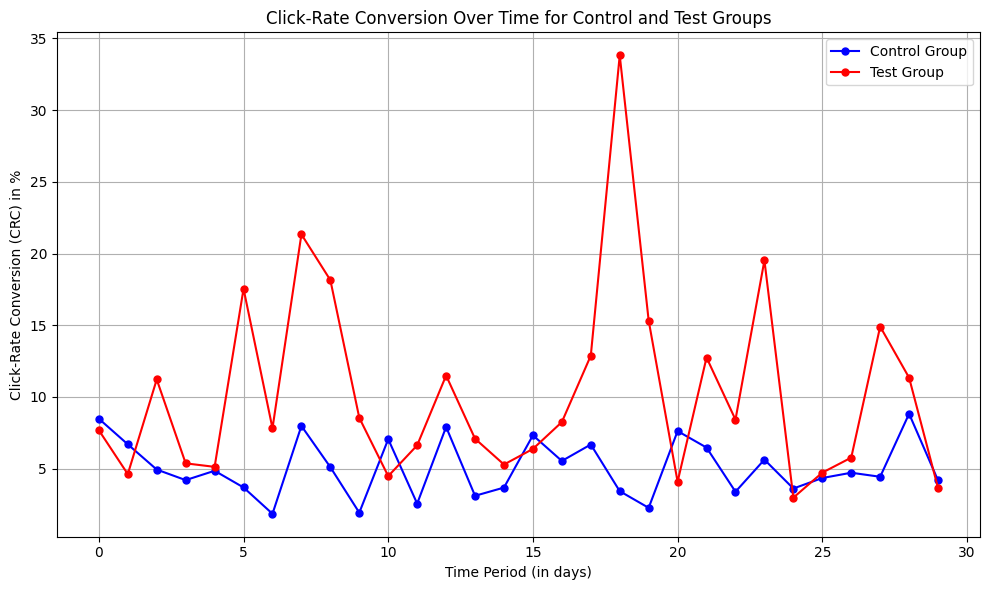

In [21]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot CRC for the control group
plt.plot(CRC_control, label='Control Group', color='blue', linestyle='-', marker='o', markersize=5)

# Plot CRC for the test group
plt.plot(CRC_test, label='Test Group', color='red', linestyle='-', marker='o', markersize=5)

# Add labels and title
plt.xlabel('Time Period (in days)')
plt.ylabel('Click-Rate Conversion (CRC) in %')
plt.title('Click-Rate Conversion Over Time for Control and Test Groups')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that it seems that the new ad campaign is more efficient than the default one, but is it statistically significant?

In [22]:
from scipy import stats
tc, pc = stats.ttest_ind(CRC_control, CRC_test)
print ("t-test: t = %g  p = %g" % (tc, pc))

t-test: t = -3.99625  p = 0.000183985


Based on the t-test results (`p-value = 0 < 0.05`), we can conclude that there is a statistically significant difference between the control group and the test group: the new ad campaign did result in a higher click-rate conversion one on average.

In a real case, other factors would have to be considered to decide whether to implement this new type of campaign, for e.g.: what is the additional cost of this new type of campaign? Is this increase in click-rate conversion actually results in more purchases?